In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
import librosa
import soundfile as sf
import pywt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Wavelet Transform Harmonics Detector for Underwater Acoustic Signals

This notebook implements advanced harmonics detection using continuous wavelet transforms and cyclo-stationary analysis for underwater acoustic target recognition, specifically designed for scooter/DPV detection.

## Implementation Overview
- **Continuous Wavelet Transform (CWT)** for time-frequency analysis
- **Cyclo-stationary Analysis** for periodic pattern detection  
- **Multi-scale Harmonics Detection** with validation
- **Advanced Visualization** of detected patterns

In [1]:
import numpy as np
import scipy.signal as sig
import pywt
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display


In [2]:
data_file = "../data/scooter_example_1.wav"
data, fs = librosa.load(data_file, sr=None)

# crop data
start_time = 95 # seconds
end_time = 100 # seconds
data = data[int(start_time*fs):int(end_time*fs)]

In [3]:
# -------------------------
# Config object
# -------------------------
class PipelineConfig:
    def __init__(self,
                 fs,
                 stft_nfft=16384,
                 overlap=0.5,
                 f0_min=10.0,
                 f0_max=200.0,
                 f0_bins=400,
                 max_harm=12,
                 demon_band=(80, 3000),
                 demon_frame=2.0,
                 demon_hop=0.5):
        self.fs = fs
        self.stft_nfft = stft_nfft
        self.stft_hop =int(stft_nfft * (1 - overlap))
        self.f0_min = f0_min
        self.f0_max = f0_max
        self.f0_bins = f0_bins
        self.max_harm = max_harm
        self.demon_band = demon_band
        self.demon_frame = demon_frame
        self.demon_hop = demon_hop

cfg = PipelineConfig(fs)

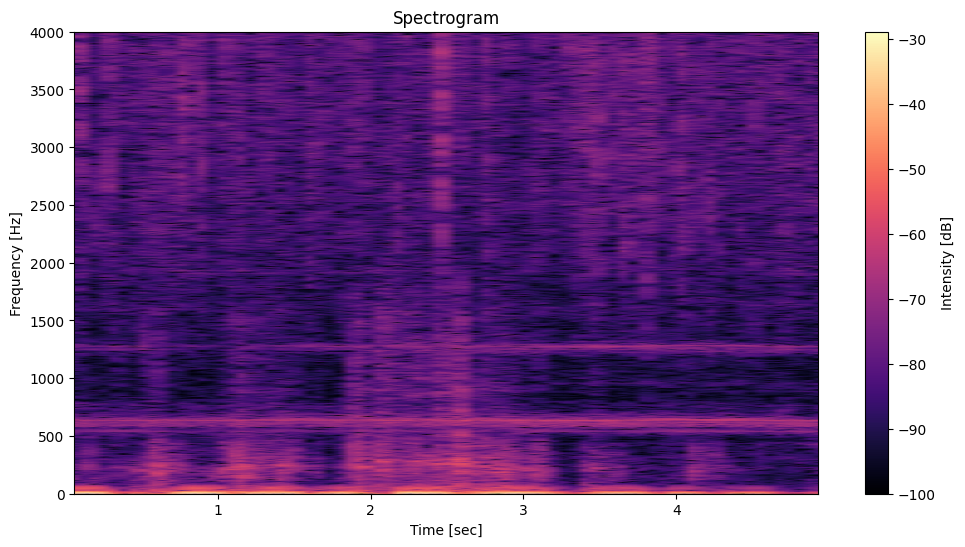

In [17]:
# -------------------------
# Plot Spectrogram
# -------------------------
def plot_spectrogram(data, 
                     fs=cfg.fs, 
                     nfft=cfg.stft_nfft, 
                     hop=cfg.stft_hop, 
                     title="Spectrogram", 
                     color_map='magma', 
                     crop_freq=4000):
    f, t, Sxx = sig.spectrogram(data, fs, nperseg=nfft, noverlap=nfft - hop)
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap=color_map)
    plt.colorbar(label='Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.ylim(0, min(fs / 2, crop_freq))
    plt.show()

plot_spectrogram(data)

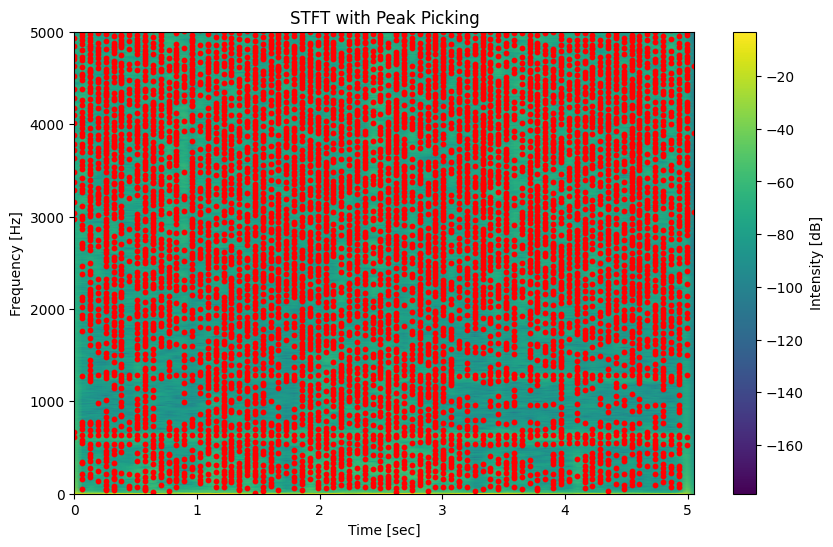

In [18]:
# -------------------------
# STFT + peak picking
# -------------------------
def compute_stft(x, cfg):
    f, t, S = sig.stft(
        x,
        fs=cfg.fs,
        nperseg=cfg.stft_nfft,
        noverlap=cfg.stft_nfft - cfg.stft_hop,
        nfft=cfg.stft_nfft,
        return_onesided=True
    )
    return f, t, np.abs(S)

def stft_peak_pick(S, f, cfg, prominence=6.0):
    peaks_per_frame = []
    for frame in range(S.shape[1]):
        spec = 20 * np.log10(S[:, frame] + 1e-9)
        med = np.median(spec)
        idx, _ = sig.find_peaks(spec, prominence=prominence, height=med + prominence)
        peaks_per_frame.append(f[idx])
    return peaks_per_frame

def plot_stft_peaks(f, t, S, peaks_per_frame):
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 20 * np.log10(S + 1e-9), shading='gouraud')
    plt.colorbar(label='Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    for i, peaks in enumerate(peaks_per_frame):
        plt.scatter([t[i]] * len(peaks), peaks, color='red', s=10)
    plt.title('STFT with Peak Picking')
    plt.ylim(0, 5000)
    plt.show()

f, t, S = compute_stft(data, cfg)
peaks_per_frame = stft_peak_pick(S, f, cfg, prominence=6.0)
plot_stft_peaks(f, t, S, peaks_per_frame)


Estimated F0 (Cepstrum): [np.float64(16.0), np.float64(132.09494324045409), np.float64(25.211739216072484), np.float64(127.7445109780439), np.float64(15.138971023063275), np.float64(15.138971023063275)]


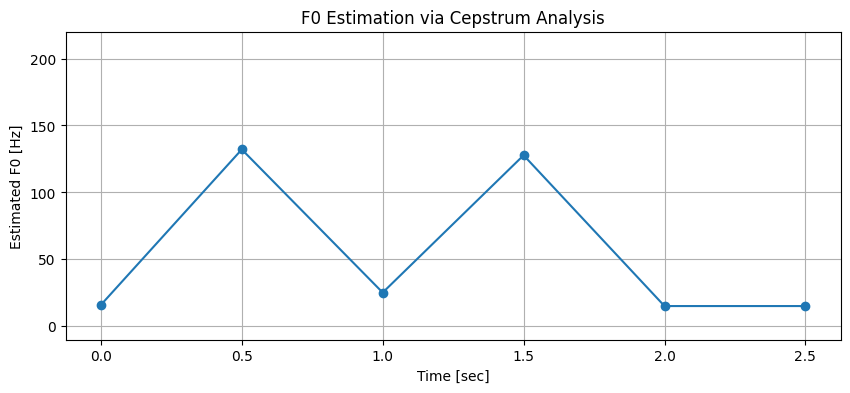

In [21]:
# -------------------------
# Cepstrum analysis
# -------------------------
def cepstrum_f0(x, cfg):
    n = int(cfg.fs * cfg.demon_frame)
    step = int(cfg.fs * cfg.demon_hop)
    frames = []
    for i in range(0, len(x) - n, step):
        frame = x[i:i+n] * np.hanning(n)
        spectrum = np.fft.rfft(frame)
        log_mag = np.log(np.abs(spectrum) + 1e-9)
        cep = np.fft.irfft(log_mag)
        q = np.arange(len(cep)) / cfg.fs
        mask = (q >= 1/cfg.f0_max) & (q <= 1/cfg.f0_min)
        if np.any(mask):
            q_sel = q[mask]
            idx = np.argmax(cep[mask])
            f0 = 1.0 / q_sel[idx]
            frames.append(f0)
        else:
            frames.append(None)
    return frames

def plot_cepstrum_f0(f0_cepstrum, cfg):
    times = np.arange(len(f0_cepstrum)) * cfg.demon_hop
    plt.figure(figsize=(10, 4))
    plt.plot(times, f0_cepstrum, marker='o')
    plt.xlabel('Time [sec]')
    plt.ylabel('Estimated F0 [Hz]')
    plt.title('F0 Estimation via Cepstrum Analysis')
    plt.ylim(cfg.f0_min - 20, cfg.f0_max + 20)
    plt.grid()
    plt.show()


f0_cepstrum = cepstrum_f0(data, cfg)
print("Estimated F0 (Cepstrum):", f0_cepstrum)
plot_cepstrum_f0(f0_cepstrum, cfg)

Estimated F0 (DEMON): [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


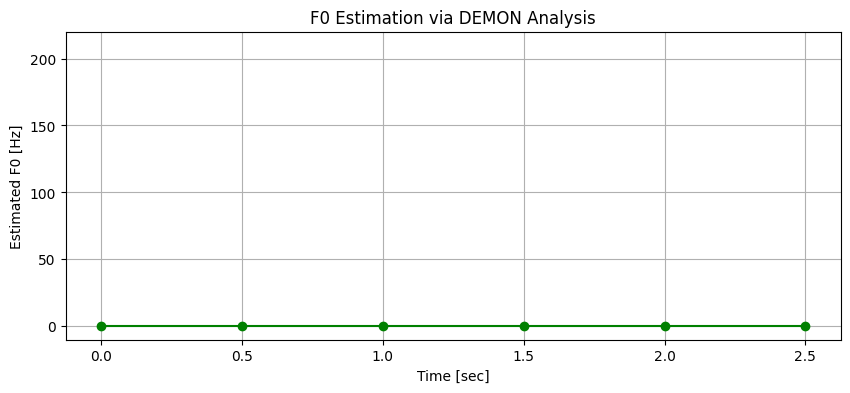

In [24]:
# -------------------------
# DEMON analysis
# -------------------------
def demon_f0(x, cfg):
    b, a = sig.butter(4, np.array(cfg.demon_band)/(cfg.fs/2), btype='band')
    y = sig.filtfilt(b, a, x)
    env = np.abs(sig.hilbert(y))
    n = int(cfg.fs * cfg.demon_frame)
    step = int(cfg.fs * cfg.demon_hop)
    f0s = []
    for i in range(0, len(env) - n, step):
        frame = env[i:i+n] * np.hanning(n)
        spec = np.fft.rfft(frame)
        f = np.fft.rfftfreq(len(frame), 1.0/cfg.fs)
        idx = np.argmax(np.abs(spec))
        f0s.append(f[idx])
    return f0s

def plot_demon_f0(f0_demon, cfg):
    times = np.arange(len(f0_demon)) * cfg.demon_hop
    plt.figure(figsize=(10, 4))
    plt.plot(times, f0_demon, marker='o', color='green')
    plt.xlabel('Time [sec]')
    plt.ylabel('Estimated F0 [Hz]')
    plt.title('F0 Estimation via DEMON Analysis')
    plt.ylim(cfg.f0_min - 20, cfg.f0_max + 20)
    plt.grid()
    plt.show()

f0_demon = demon_f0(data, cfg)
print("Estimated F0 (DEMON):", f0_demon)
plot_demon_f0(f0_demon, cfg)

In [4]:
# -------------------------
# Wavelet scalogram energy (optional score)
# -------------------------
def wavelet_score(x, cfg):
    scales = np.arange(1, 256)
    coeffs = pywt.wavedec(x, 'db4', level=6)
    energy = np.array([np.sum(np.abs(c) ** 2) for c in coeffs])
    freqs = np.array([cfg.fs / (2 ** (i + 1)) for i in range(len(coeffs))])
    energy = np.abs(coeffs) ** 2
    return freqs, energy

def plot_wavelet_score(freqs, energy, cfg, crop_freq=5000):
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(np.arange(energy.shape[1]) * (1.0/cfg.fs), freqs, 10 * np.log10(energy + 1e-10), shading='gouraud', cmap='viridis')
    plt.colorbar(label='Energy [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Wavelet Scalogram Energy')
    plt.ylim(0, min(cfg.fs / 2, crop_freq))
    plt.show()

freqs, energy = wavelet_score(data, cfg)
plot_wavelet_score(freqs, energy, cfg)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

In [ ]:
# -------------------------
# Horizontal Edge Detector for Spectrograms
# -------------------------
from scipy.ndimage import convolve

def horizontal_edge_detector(spectrogram_db):
    """
    Simple edge detector for thin horizontal lines in spectrograms.
    
    Parameters:
    -----------
    spectrogram_db : np.array
        Spectrogram in dB scale (frequency x time)
        
    Returns:
    --------
    edges : np.array
        Edge-detected image highlighting horizontal features
    """
    
    # Simple horizontal edge detection kernel
    kernel = np.array([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]])
    
    # Apply convolution
    edges = convolve(spectrogram_db, kernel, mode='constant')
    
    # Threshold to highlight prominent edges
    threshold = np.percentile(np.abs(edges), 85)
    edges = np.abs(edges) > threshold
    
    return edges.astype(float)